In [42]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter


import pyproj
import os
import shutil

# Random number generator
rng = np.random.default_rng()

In [43]:

def generate_pert_like_da(da, sigma, correlation_scale, bias=0.0):
    # Generate random noise (mean 0, std 1) and introduce spatial correlation with Gaussian filter
    random_noise = np.random.normal(loc=0.0, scale=1.0, size=da.shape)
    
    correlated_noise = gaussian_filter(input=random_noise, sigma=correlation_scale)
    
    
    # Normalize (s.t. std = 1) and then scale to desired std
    correlated_noise /= np.std(correlated_noise)
    perturbation = correlated_noise * sigma
    
    # Apply the bias after scaling
    perturbation += bias
    
    da_delta = xr.DataArray(data=perturbation,
                            dims=da.dims,
                            coords=da.coords
                            )
    return da_delta


In [47]:

def calc_3d_wind_magnitude(da_u, da_v):
    u_vals = da_u.values
    v_vals = da_v.values
    M_vals = np.sqrt(u_vals**2 + v_vals**2)

    da_M = xr.DataArray(data=M_vals, coords=da_u.coords, dims=da_u.dims)
    return da_M

----

## TODO:

- Perturb u and v in a dependent manner, such that chage in wind direction stays somewhat reasonable


---

In [44]:
# Define directories
BASE_DIR       = "/home/maxf/projects/da4gs/esmda"
dir_base_sim   = f"{BASE_DIR}/runs/base_run/2020/04/04/00"
sims_directory = f"{BASE_DIR}/runs/run_esmda/2020/04/04/00"
data_directory = f"{BASE_DIR}/data/ensemble_data/2020/04/04/00"
obs_save_dir   = f"{BASE_DIR}/data/observation/synthetic_obs"

SAVE = True # Save perturb fields
NE   = 15   # Nr of Ensemble members



# Define added noise
sigma_u = 2  # std of u 
sigma_v = 2  # std of v
spatial_corr = 32    # Spatial correlation length scale (in grid points)

sp_corr_min = 4    # Spatial correlation length scale (in grid points)
sp_corr_max = 32    # Spatial correlation length scale (in grid points)


In [45]:

# Load the base run
ds_base = xr.open_dataset(f'{dir_base_sim}/graspOutRestart.000.nc')


---
### Generate synthetic (noisy) observations

In [124]:
##----------------------------------------------------------
## Prepare (synthetic) observations --> reference simulation
##-----------
ds_synobs_IC_field = ds_base.copy()
da_delta_u = generate_pert_like_da(da=ds_base["u"], sigma=1.5, correlation_scale=16, bias=1)
da_delta_v = generate_pert_like_da(da=ds_base["v"], sigma=1.5, correlation_scale=16, bias=-1)
## Add perturbations to fields
ds_synobs_IC_field['u'] = ds_base['u'] + da_delta_u
ds_synobs_IC_field['v'] = ds_base['v'] + da_delta_v


dir_synobs = f"{BASE_DIR}/runs/run_esmda/2020/04/04/syn_obs"
print(f"Save reference field in: {dir_synobs}")
# ds_synobs_IC_field.to_netcdf(f"{dir_synobs}/graspOutRestart.000.nc")



Save reference field in: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/syn_obs


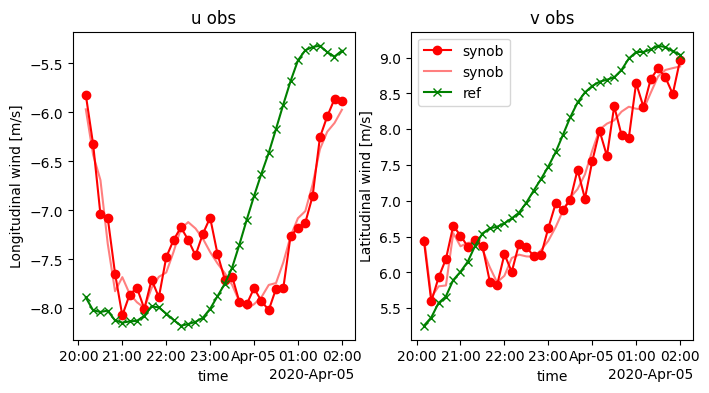

In [125]:
MEASUREMENT_NOISE = 0.2
show_plot = True
SAVE_SYNOBS=False


simdata_dir = f"{sims_directory}/graspOutSimdata.000.nc"
ds_simdat_ref   = xr.open_dataset(simdata_dir)
ds_simdat_synob = xr.open_dataset(f"{dir_synobs}/graspOutSimdata.000.nc")


## Create observation 
da_u_ref = ds_simdat_ref['u'].sel(zf=slice(0,300)).isel(xh=64, yf=64)
da_v_ref = ds_simdat_ref['v'].sel(zf=slice(0,300)).isel(xf=64, yh=64)

da_u_synob = ds_simdat_synob['u'].sel(zf=slice(0,300)).isel(xh=64, yf=64)
da_v_synob = ds_simdat_synob['v'].sel(zf=slice(0,300)).isel(xf=64, yh=64)



## Add noise to create noisy observations
dstd = np.ones(da_u_synob.shape) * MEASUREMENT_NOISE

da_u_synob_noisy = da_u_synob + np.random.normal(0, dstd , size=da_u_synob.shape)
da_v_synob_noisy = da_v_synob + np.random.normal(0, dstd , size=da_v_synob.shape)

ds_synob = xr.Dataset({
    'u': da_u_synob_noisy,
    'v': da_v_synob_noisy
    })



# Save synoptic observations
if SAVE_SYNOBS:
    ds_synob.to_netcdf(f'{obs_save_dir}/ds_obs_synthetic.nc')


if show_plot:
    fig,ax = plt.subplots(ncols=2, figsize=(8,4))
    da_u_synob_noisy.isel(zf=5).plot(marker='o', c='red', ax=ax[0], label='synob')
    da_u_synob.isel(zf=5).plot(c='red', ax=ax[0], label='synob', alpha=.5)
    da_u_ref.isel(zf=5).plot(marker='x', c='green', ax=ax[0], label='ref')
    ax[0].set_title('u obs')

    da_v_synob_noisy.isel(zf=5).plot(marker='o', c='red', ax=ax[1], label='synob')
    da_v_synob.isel(zf=5).plot(c='red', ax=ax[1], label='synob', alpha=.5)
    da_v_ref.isel(zf=5).plot(marker='x', c='green', ax=ax[1], label='ref')
    ax[1].set_title('v obs')

    ax[1].legend()

---
## Generate I.C. for ensemble 
- Ensemble differ in input field
- Initital condition is modified by adding spatially correlated Gaussian noise (after spin-up)
- Reference simulation is spin-up field WITHOUT modification 

In [66]:
SAVE=False

# Get the shape of the wind fields
field_shape = ds_base['u'].shape


list_ds_init = []
list_delta_u = []
list_delta_v = []
for i in range(NE+1):     # +1 due to reference sim

    # First create referecne file (ref-file has no modification)
    ds_base_mem = ds_base.copy(deep=True)
    
    if i != 0:
        # Generate new perturbations for each ensemble member
        sp_co = sp_corr_min + np.ceil((sp_corr_max-sp_corr_min)*(i+1) / NE)

        da_delta_u = generate_pert_like_da(da=ds_base["u"], sigma=sigma_u, correlation_scale=sp_co)
        da_delta_v = generate_pert_like_da(da=ds_base["v"], sigma=sigma_v, correlation_scale=sp_co)
        ## Add perturbations to fields
        ds_base_mem['u'] = ds_base_mem['u'] + da_delta_u
        ds_base_mem['v'] = ds_base_mem['v'] + da_delta_v

        list_delta_u.append(xr.DataArray(data=da_delta_u, coords=list_ds_init[0]['u'].coords, dims=list_ds_init[0]['u'].dims))
        list_delta_v.append(xr.DataArray(data=da_delta_v, coords=list_ds_init[0]['v'].coords, dims=list_ds_init[0]['v'].dims))
    # Append member to list for later usage
    list_ds_init.append(ds_base_mem)

    # Save file to new directory 
    if SAVE:
        if i == 0:
            outdir = sims_directory
            print_msg = f"Save reference field in: {outdir}"

        else:
            outdir = f"{sims_directory}_m{str(i).zfill(2)}"
    
            # If the member-directory does not yet exist, first copy the base directory, otherwise other input fields are missing
            if not os.path.exists(outdir):
                shutil.copytree(f"{BASE_DIR}/runs/run_esmda/2020/04/04/00", outdir)
            print_msg = f"Save perturbed field in: {outdir} ,  sp_co is {sp_co}"
        
        print(print_msg)
        ds_base_mem.to_netcdf(f"{outdir}/graspOutRestart.000.nc")

  

    # # Verification that modifiction happens
    # if i > 0:
    #     delta_u = list_ds_init[i]['u'].mean(dim='zf') - list_ds_init[i-1]['u'].mean(dim='zf')
    #     print("Max perturbation in u:", delta_u.max().values)


In [ ]:
M_init_field = []
for ds in (list_ds_init):
    da_M = calc_3d_wind_magnitude(da_u=ds['u'], da_v=ds['v'])
    M_init_field.append(da_M)

---
---
# Figures for report

In [109]:
da_M_list = []
# for i in range(len(list_ds_init)):
for da_u_p, da_v_p in zip(list_delta_u, list_delta_v):
    da_M_list.append(calc_3d_wind_magnitude(da_u=da_u_p, da_v=da_v_p))


da_m_base = calc_3d_wind_magnitude(da_u=ds_base['u'], da_v=ds_base['v'])

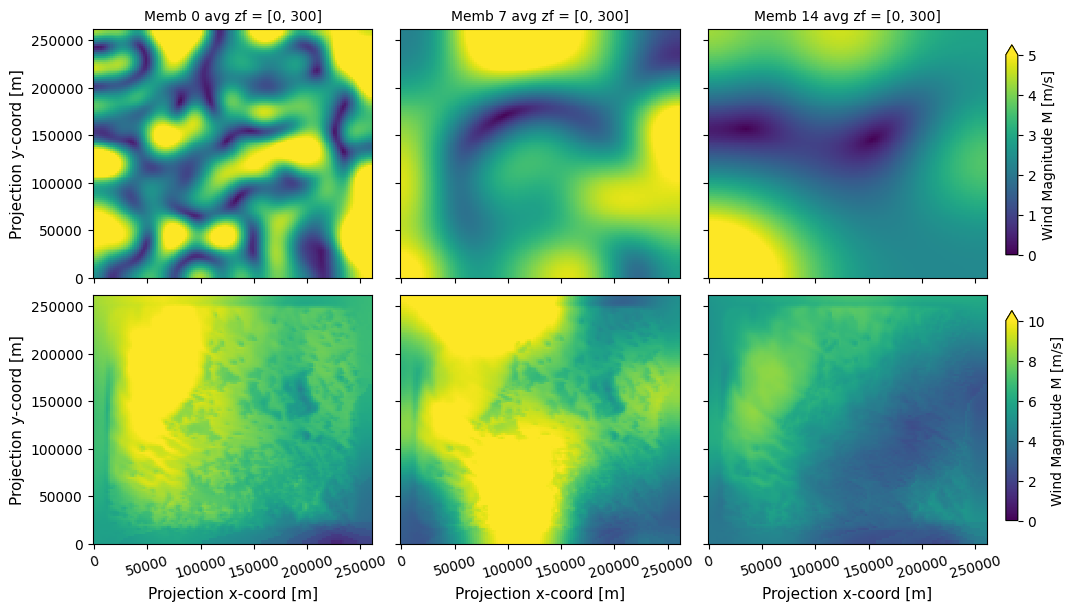

In [123]:
import matplotlib.pyplot as plt
import xarray as xr

# Define plot parameters
bound_min = 0
bound_max = 10
zf_top = 300
show_ens = [0, 7, 14]
z_top = 300

# Create figure and axes
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharex=True, sharey=True, constrained_layout=True)

axs = ax.flatten()
title_list = [f"Memb {show_ens[0]} avg zf = [0, {zf_top}]",
              f"Memb {show_ens[1]} avg zf = [0, {zf_top}]",
              f"Memb {show_ens[2]} avg zf = [0, {zf_top}]"]

# Plot the first row with da_M_list
for i in range(3):
    im = da_M_list[show_ens[i]].sel(zf=slice(0, z_top)).mean(dim='zf').plot(
        ax=axs[i], vmin=0, vmax=bound_max - 5, add_colorbar=False, cmap='viridis'
    )

    axs[i].set_title(title_list[i], fontsize=10)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    if i == 0:
        axs[i].set_ylabel("Projection y-coord [m]", fontsize=11)

# Plot the second row with M_init_field
for i in range(3):
    im = M_init_field[show_ens[i]].sel(zf=slice(0, zf_top)).mean(dim='zf').plot(
        ax=axs[i + 3], vmin=0, vmax=bound_max, add_colorbar=False, cmap='viridis'
    )
    axs[i + 3].set_xlabel("Projection x-coord [m]", fontsize=11)
    if i == 0:
        axs[i + 3].set_ylabel("Projection y-coord [m]", fontsize=11)
    axs[i + 3].tick_params(axis="x", rotation=15)

# Add colorbars without resizing plots
cbar_ax_top = fig.add_axes(   [1, 0.584, 0.012, 0.35])  # Position for top row colorbar
cbar_ax_bottom = fig.add_axes([1, 0.141, 0.012, 0.35])  # Position for bottom row colorbar
fig.colorbar(axs[0].collections[0], cax=cbar_ax_top, orientation='vertical', label="Wind Magnitude M [m/s]", extend='max')
fig.colorbar(axs[3].collections[0], cax=cbar_ax_bottom, orientation='vertical', label="Wind Magnitude M [m/s]", extend='max')

for i in range(6):
    if i %3 != 0:
        axs[i].set_ylabel("")

# Final adjustments
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


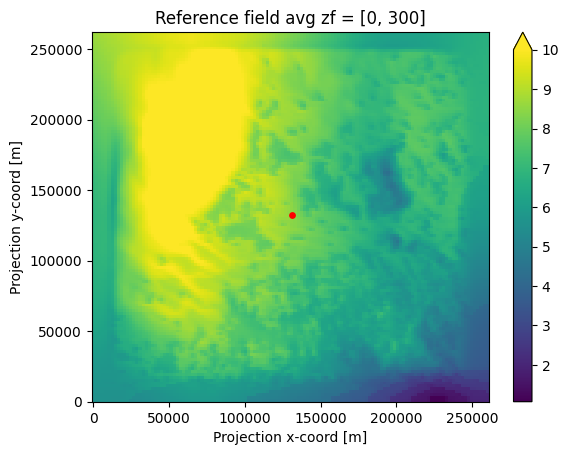

In [120]:
im = da_m_base.sel(zf=slice(0,300)).mean(dim='zf').plot(vmax=10)
plt.xlabel("Projection x-coord [m]", fontsize=10)
plt.ylabel("Projection y-coord [m]", fontsize=10)
plt.title("Reference field avg zf = [0, 300]")


x_cbw = da_m_base.xh.values[64]
y_cbw = da_m_base.yf.values[64]
plt.scatter(x_cbw, y_cbw, c='red', s=15)

#### Finish figure for report section
---

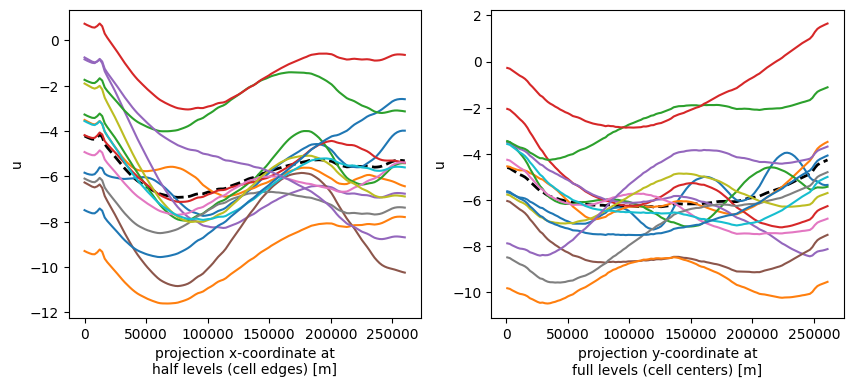

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

for i,ds in enumerate(list_ds_init):
    if i == 0:
        ds['u'].isel(zf=slice(0,15)).mean(dim='yf').mean(dim='zf').plot(c='k', linewidth=2, linestyle='--', ax=ax[0])
    else:
        ds['u'].isel(zf=slice(0,15)).mean(dim='yf').mean(dim='zf').plot(ax=ax[0])

for i,ds in enumerate(list_ds_init):
    if i == 0:
        ds['u'].isel(zf=slice(0,15)).mean(dim='xh').mean(dim='zf').plot(c='k', linewidth=2, linestyle='--', ax=ax[1])
    else:
        ds['u'].isel(zf=slice(0,15)).mean(dim='xh').mean(dim='zf').plot(ax=ax[1])

plt.show()

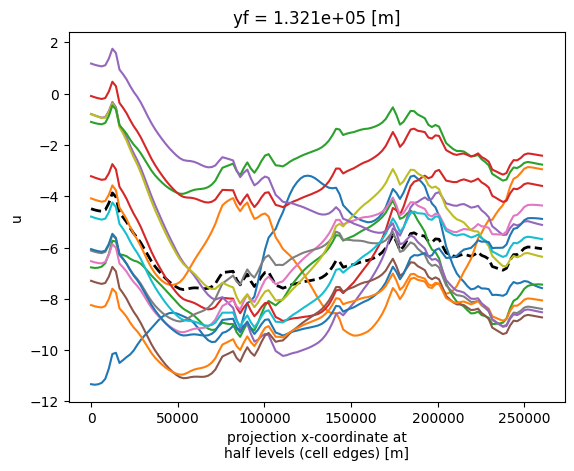

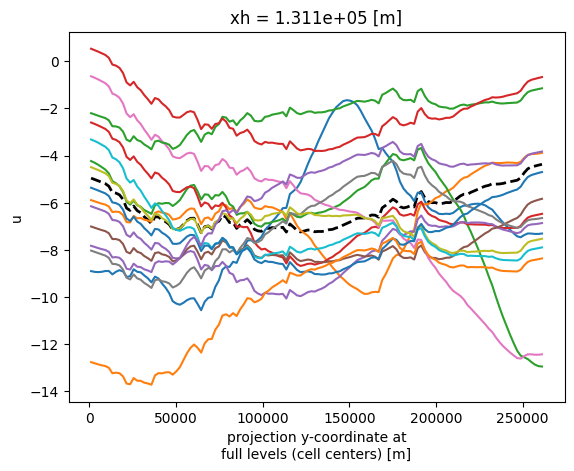

In [10]:
for i,ds in enumerate(list_ds_init):
    if i == 0:
        ds['u'].isel(yf=64, zf=slice(0,11)).mean(dim='zf').plot(c='k', linewidth=2, linestyle='--')
    else:
        ds['u'].isel(yf=64, zf=slice(0,11)).mean(dim='zf').plot()

plt.show()

for i,ds in enumerate(list_ds_init):
    if i == 0:
        ds['u'].isel(xh=64, zf=slice(0,11)).mean(dim='zf').plot(c='k', linewidth=2, linestyle='--')
    else:
        ds['u'].isel(xh=64, zf=slice(0,11)).mean(dim='zf').plot()

plt.show()

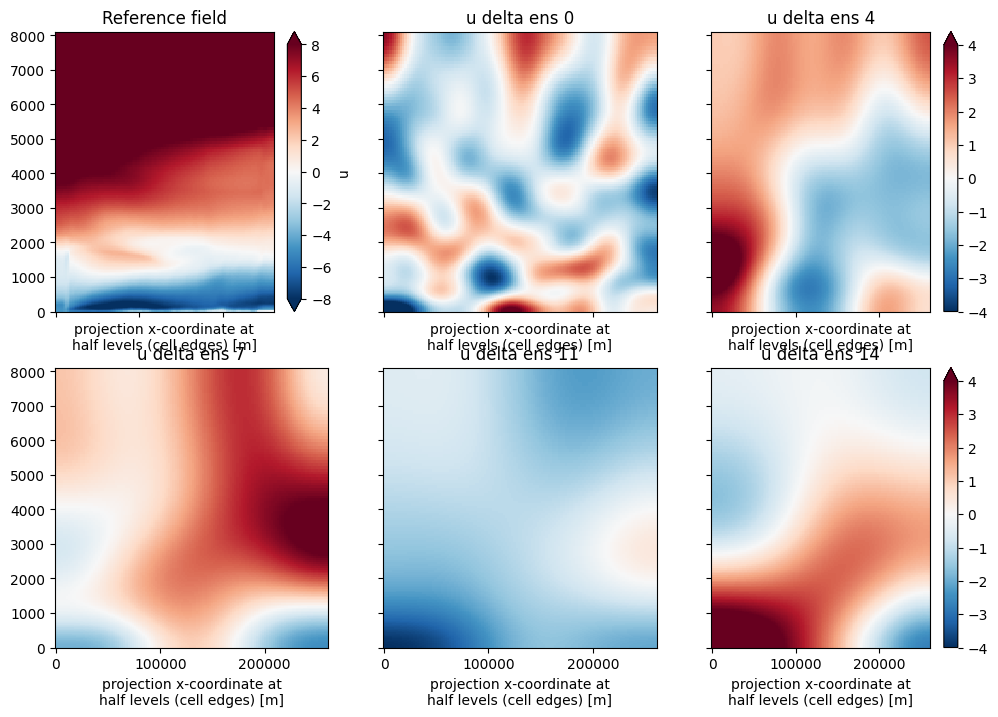

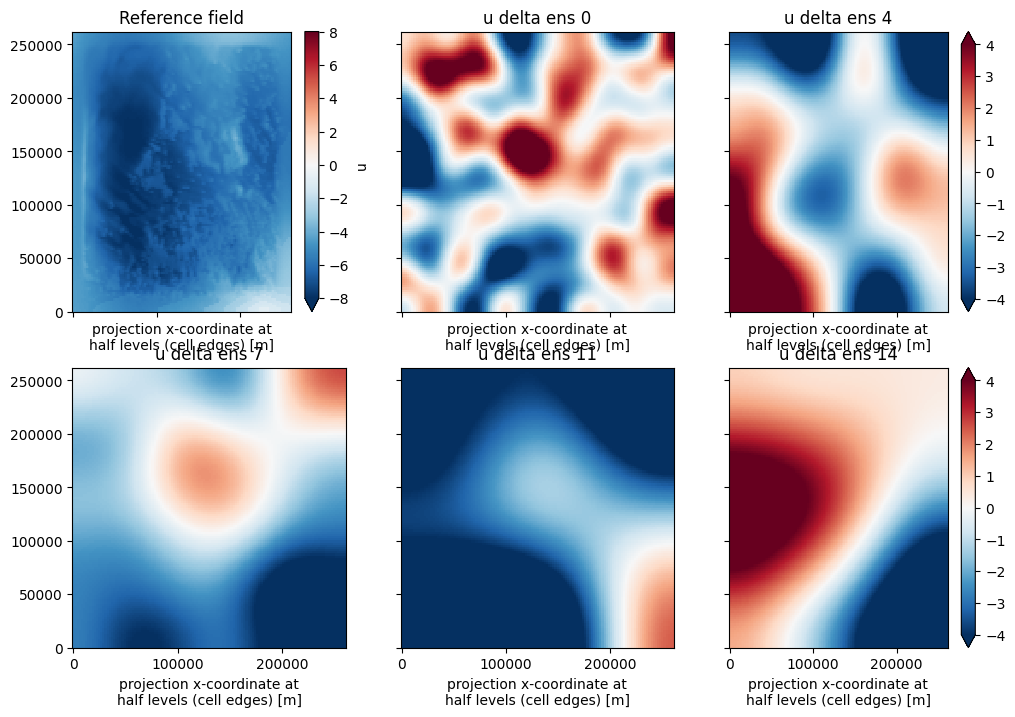

In [11]:
#plot the MReference

bound_max = 4


show_ens = [0,4,7,11,14]

# Create a figure and axis with a specific size
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharey=True, sharex=True)

axs=ax.flatten()

# Plot your data (assuming PlotModelRealization is a custom function you have)

im = list_ds_init[0]['u'].isel(yf=slice(48,80)).mean(dim='yf').plot(ax=axs[0], vmax=8)
im = list_delta_u[show_ens[0]].isel(yf=slice(48,80)).mean(dim='yf').plot(ax=axs[1], vmax=bound_max, add_colorbar=False)
im = list_delta_u[show_ens[1]].isel(yf=slice(48,80)).mean(dim='yf').plot(ax=axs[2], vmax=bound_max, add_colorbar=True)
im = list_delta_u[show_ens[2]].isel(yf=slice(48,80)).mean(dim='yf').plot(ax=axs[3], vmax=bound_max, add_colorbar=False)
im = list_delta_u[show_ens[3]].isel(yf=slice(48,80)).mean(dim='yf').plot(ax=axs[4], vmax=bound_max, add_colorbar=False)
im = list_delta_u[show_ens[4]].isel(yf=slice(48,80)).mean(dim='yf').plot(ax=axs[5], vmax=bound_max, add_colorbar=True)

axs[0].set_title(f"Reference field")
axs[1].set_title(f"u delta ens {show_ens[0]}")
axs[2].set_title(f"u delta ens {show_ens[1]}")
axs[3].set_title(f"u delta ens {show_ens[2]}")
axs[4].set_title(f"u delta ens {show_ens[3]}")
axs[5].set_title(f"u delta ens {show_ens[4]}")

for axis in axs:
    # axis.set_xlabel('')
    axis.set_ylabel('')
#     axis.set_xticks([])
#     axis.set_yticks([])

plt.show()

# Create a figure and axis with a specific size
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharey=True, sharex=True)

axs=ax.flatten()

z_top = 300

im = list_ds_init[0]['u'     ].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[0], vmax=8)
im = list_delta_u[show_ens[0]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[1], vmax=bound_max, add_colorbar=False)
im = list_delta_u[show_ens[1]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[2], vmax=bound_max, add_colorbar=True)
im = list_delta_u[show_ens[2]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[3], vmax=bound_max, add_colorbar=False)
im = list_delta_u[show_ens[3]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[4], vmax=bound_max, add_colorbar=False)
im = list_delta_u[show_ens[4]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[5], vmax=bound_max, add_colorbar=True)





axs[0].set_title(f"Reference field")
axs[1].set_title(f"u delta ens {show_ens[0]}")
axs[2].set_title(f"u delta ens {show_ens[1]}")
axs[3].set_title(f"u delta ens {show_ens[2]}")
axs[4].set_title(f"u delta ens {show_ens[3]}")
axs[5].set_title(f"u delta ens {show_ens[4]}")

for axis in axs:
    # axis.set_xlabel('')
    axis.set_ylabel('')
#     axis.set_xticks([])
#     axis.set_yticks([])

plt.show()

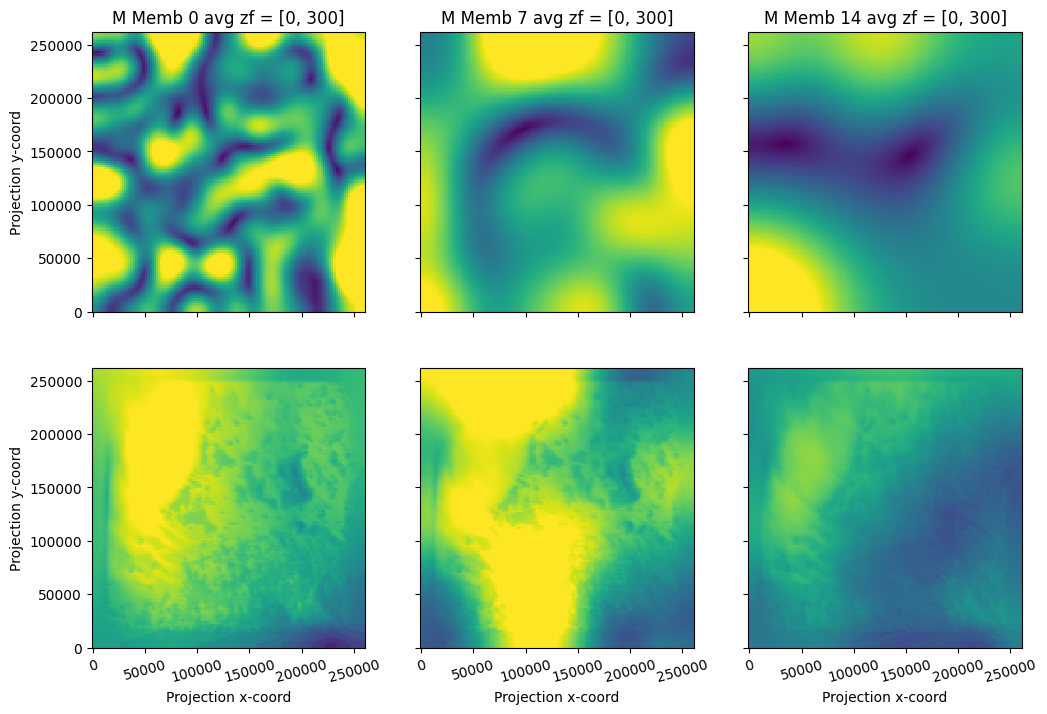

In [78]:
#plot the MReference

#plot the MReference
bound_min = 0
bound_max = 10
zf_top = 300

show_ens = [0,7,14]


# Create a figure and axis with a specific size
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharey=True, sharex=True)

axs=ax.flatten()

z_top = 300

im = da_M_list[show_ens[0]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[0], vmin=0, vmax=bound_max-5, add_colorbar=False)
im = da_M_list[show_ens[1]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[1], vmin=0, vmax=bound_max-5, add_colorbar=False)
im = da_M_list[show_ens[2]].sel(zf=slice(0,z_top)).mean(dim='zf').plot(ax=axs[2], vmin=0, vmax=bound_max-5, add_colorbar=False)

im = M_init_field[show_ens[0]].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=axs[3], vmin=0, vmax=bound_max, add_colorbar=False)
im = M_init_field[show_ens[1]].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=axs[4], vmin=0, vmax=bound_max, add_colorbar=False)
im = M_init_field[show_ens[2]].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=axs[5], vmin=0, vmax=bound_max, add_colorbar=False )



title_list = [f"M Memb {show_ens[0]} avg zf = [0, {zf_top}]",
              f"M Memb {show_ens[1]} avg zf = [0, {zf_top}]",
              f"M Memb {show_ens[2]} avg zf = [0, {zf_top}]"]

for i, axis in enumerate(axs):
    if i < 3:
        axis.set_title(title_list[i])
    # Handle x and y-axis lavels
    axis.set_xlabel('')
    axis.set_ylabel('')
    if i > 2:
        axis.tick_params(axis="x", rotation=15)  # Rotate dates for readability
        axis.set_xlabel("Projection x-coord")

    if i % 3==0:
        axis.set_ylabel("Projection y-coord")


plt.show()

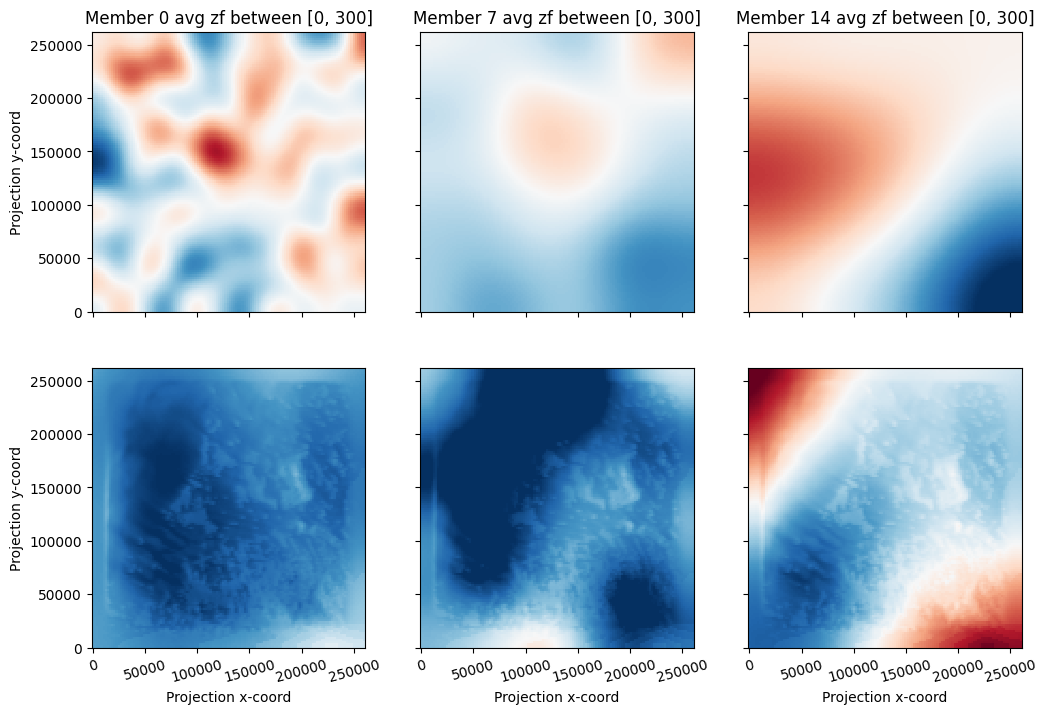

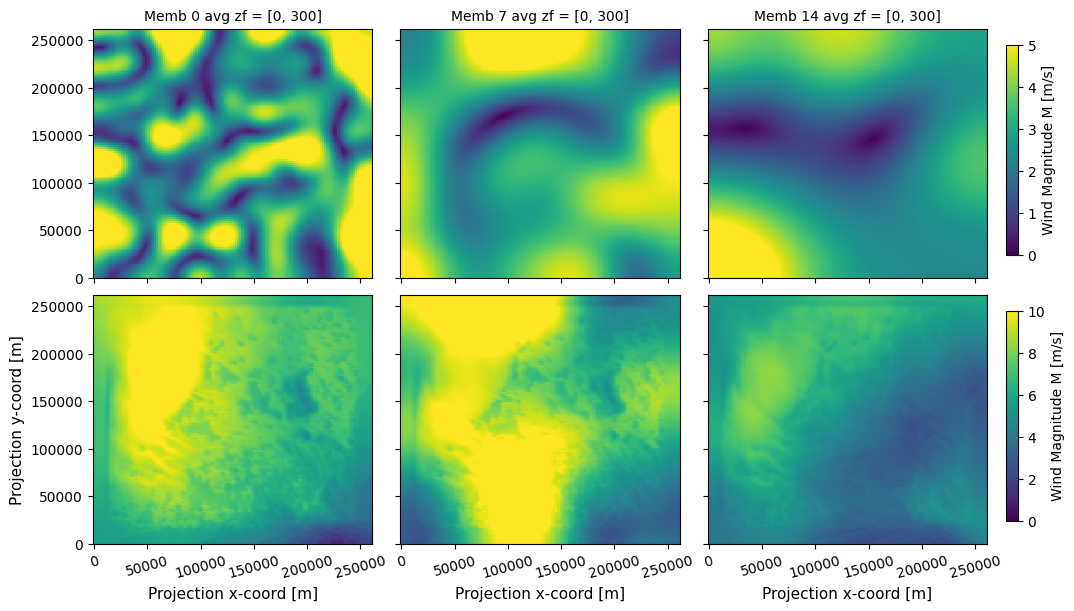

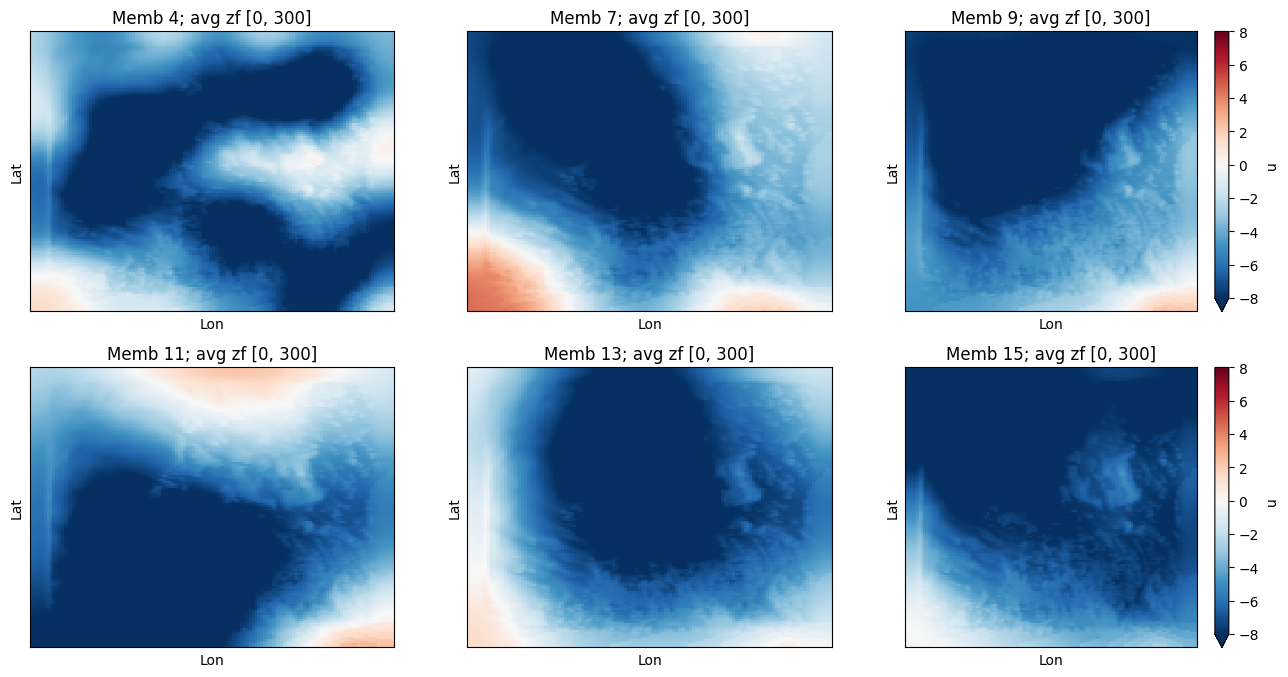

In [55]:
#plot the MReference
bound_min = -8
bound_max = 8


# Create a figure and axis with a specific size
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharey=True)

ax=axs.flatten()

zf_top = 300

# Plot your data (assuming PlotModelRealization is a custom function you have)
im = list_ds_init[3]['u'].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=ax[0], vmax=bound_max, add_colorbar=False)
im = list_ds_init[6]['u'].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=ax[1], vmax=bound_max, add_colorbar=False)
im = list_ds_init[8]['u'].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=ax[2], vmax=bound_max)
im = list_ds_init[10]['u'].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=ax[3], vmax=bound_max, add_colorbar=False)
im = list_ds_init[12]['u'].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=ax[4], vmax=bound_max, add_colorbar=False)
im = list_ds_init[14]['u'].sel(zf=slice(0,zf_top)).mean(dim='zf').plot(ax=ax[5], vmax=bound_max, add_colorbar=True )

ax[0].set_title(f"Memb 4; avg zf [0, {zf_top}]")
ax[1].set_title(f"Memb 7; avg zf [0, {zf_top}]")
ax[2].set_title(f"Memb 9; avg zf [0, {zf_top}]")
ax[3].set_title(f"Memb 11; avg zf [0, {zf_top}]")
ax[4].set_title(f"Memb 13; avg zf [0, {zf_top}]")
ax[5].set_title(f"Memb 15; avg zf [0, {zf_top}]")


for axis in ax:
    axis.set_xlabel('Lon')
    axis.set_ylabel('Lat')
    axis.set_xticks([])
    axis.set_yticks([])
# Show the plot
plt.show()

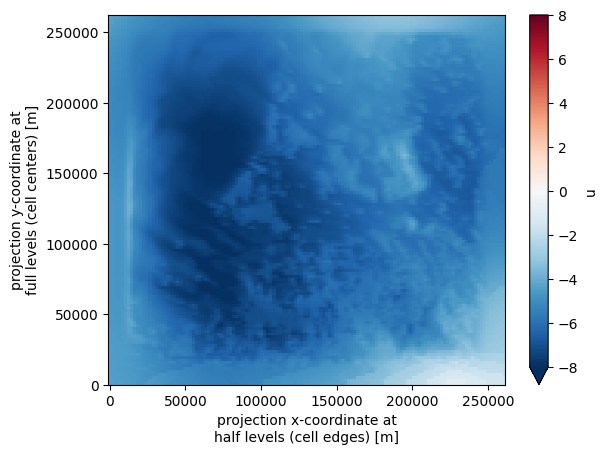

In [48]:
im = list_ds_init[0]['u'].sel(zf=slice(0,300)).mean(dim='zf').plot(vmax=8)


In [56]:
# dir = "/home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00"
# ds_ref = xr.open_dataset(f"{dir}/graspOutRestart.000.nc")
# ds_m01 = xr.open_dataset(f"{dir}_m01/graspOutRestart.000.nc")
# ds_m02 = xr.open_dataset(f"{dir}_m02/graspOutRestart.000.nc")
# ds_m03 = xr.open_dataset(f"{dir}_m03/graspOutRestart.000.nc")
# ds_m04 = xr.open_dataset(f"{dir}_m04/graspOutRestart.000.nc")
# ds_m05 = xr.open_dataset(f"{dir}_m05/graspOutRestart.000.nc")
# test_list = [ds_ref, ds_m01,ds_m02,ds_m03,ds_m04,ds_m05]


# #plot the MReference
# bound_min = -8
# bound_max = 8


# # Create a figure and axis with a specific size
# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)

# ax = axs.flatten()

# # Plot your data (assuming PlotModelRealization is a custom function you have)
# im = test_list[0]['u'].isel(zf=5).plot(ax=ax[0], vmax=bound_max, add_colorbar=False)
# im = test_list[1]['u'].isel(zf=5).plot(ax=ax[1], vmax=bound_max, add_colorbar=False)
# im = test_list[2]['u'].isel(zf=5).plot(ax=ax[2], vmax=bound_max, add_colorbar=True)
# im = test_list[3]['u'].isel(zf=5).plot(ax=ax[3], vmax=bound_max, add_colorbar=False)
# im = test_list[4]['u'].isel(zf=5).plot(ax=ax[4], vmax=bound_max, add_colorbar=False)
# # im = test_list[5]['u'].isel(zf=5).plot(ax=ax[5], vmax=bound_max, add_colorbar=True)

# ax[0].set_title("Reference Simulation")
# ax[1].set_title("Realization 1")
# ax[2].set_title("Realization 2")
# ax[3].set_title("Realization 3")
# ax[4].set_title("Realization 4")
# # ax[5].set_title("Realization 5")

#plot the MReference
# bound_max = 5
# bound_min = 0


# # Create a figure and axis with a specific size
# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)

# ax = axs.flatten()

# # Plot your data (assuming PlotModelRealization is a custom function you have)
# im = test_list[0]['v'].isel(zf=5).plot(ax=ax[0], vmax=bound_max, vmin=bound_min, add_colorbar=False)
# im = test_list[1]['v'].isel(zf=5).plot(ax=ax[1], vmax=bound_max, vmin=bound_min, add_colorbar=False)
# im = test_list[2]['v'].isel(zf=5).plot(ax=ax[2], vmax=bound_max, vmin=bound_min, add_colorbar=True)
# im = test_list[3]['v'].isel(zf=5).plot(ax=ax[3], vmax=bound_max, vmin=bound_min, add_colorbar=False)
# im = test_list[4]['v'].isel(zf=5).plot(ax=ax[4], vmax=bound_max, vmin=bound_min, add_colorbar=False)
# im = test_list[5]['v'].isel(zf=5).plot(ax=ax[5], vmax=bound_max, vmin=bound_min, add_colorbar=True)

# ax[0].set_title("Reference Simulation")
# ax[1].set_title("Realization 1")
# ax[2].set_title("Realization 2")
# ax[3].set_title("Realization 3")
# ax[4].set_title("Realization 4")
# ax[5].set_title("Realization 5")

Text(0.5, 1.0, 'Realization 5')

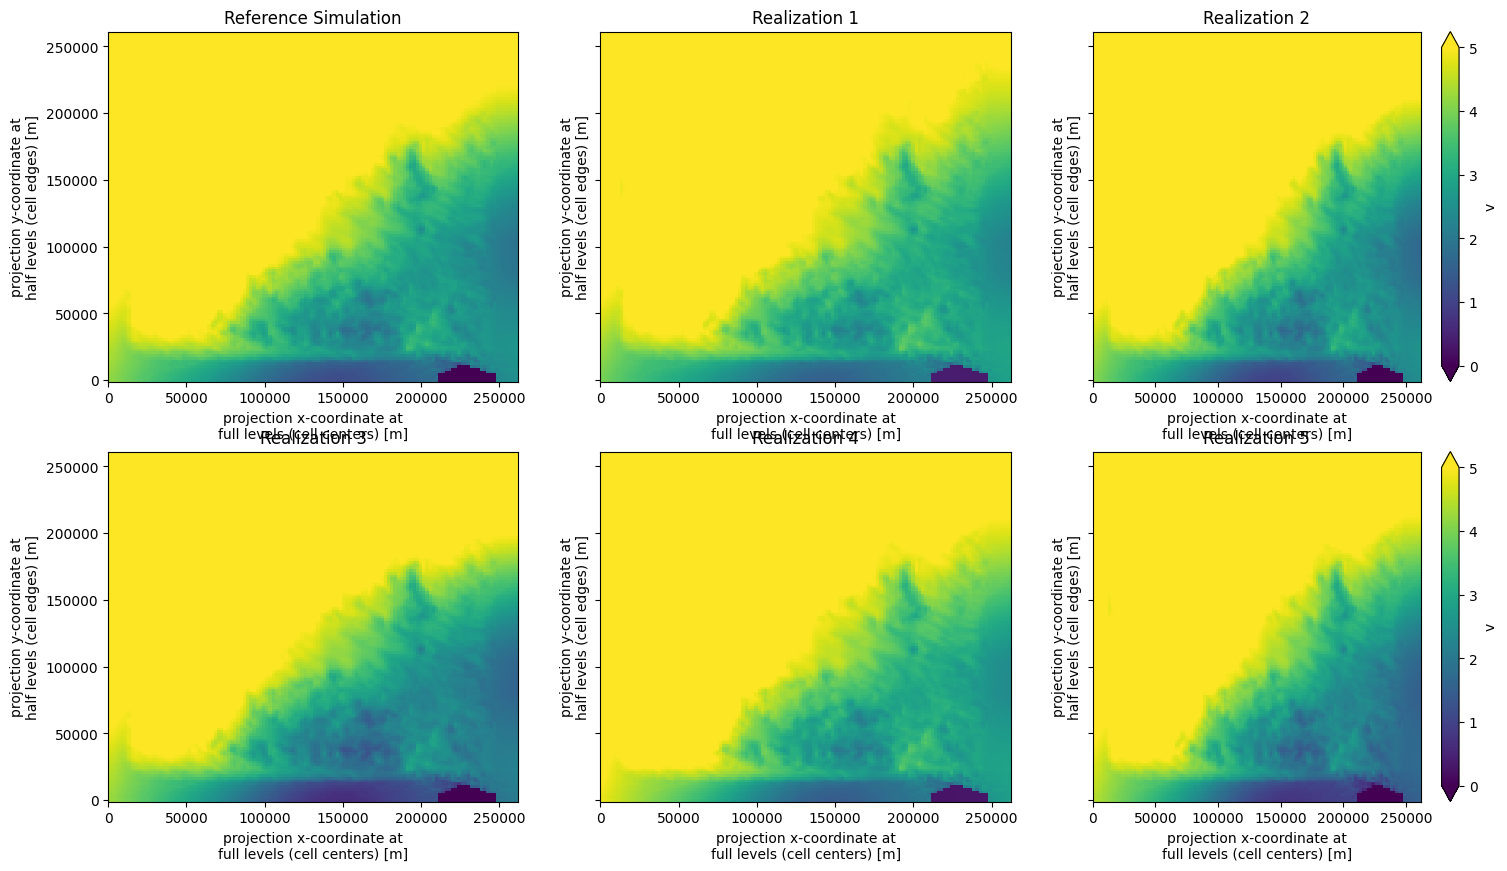

In [15]:
#